### Import Dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import set_config

set_config(transform_output='pandas')


### Loading the Data

In [3]:
df = pd.read_csv('data/raw/dataset.csv')
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


### Data Cleaning Transformers

In [4]:
class DataCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, totalcharges_col="TotalCharges", target_col="Churn"):
        self.totalcharges_col = totalcharges_col
        self.target_col = target_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.totalcharges_col] = pd.to_numeric(X[self.totalcharges_col], errors="coerce")
        X[self.target_col] = X[self.target_col].map({"Yes": 1, "No": 0})
        
        return X

### Feature Engineering Transformers

In [5]:
class TenureBinner(BaseEstimator, TransformerMixin):
    def __init__(self, col = 'tenure'):
        self.col = col

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        bins = [0, 12, 48, float('inf')]
        labels = ['New', 'Established', 'Loyal']

        X['TenureBins'] = pd.cut(X[self.col], bins=bins, labels=labels, right= True, include_lowest=True)
        return X

In [6]:
class AvgChargePerService(BaseEstimator, TransformerMixin):
    def __init__(self, service_cols=None, monthlyCharge_col = 'MonthlyCharges'):
        if service_cols is None:
            self.service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
        else:
            self.service_cols = service_cols
        self.monthlyCharge_col = monthlyCharge_col

    def fit(self, X, y=None):
            return self

    def transform(self, X):
            X = X.copy()

            services_binary = X[self.service_cols].replace({'Yes': 1, 'No': 0, 'No internet service': 0})
            X['AvgChargePerService'] = X[self.monthlyCharge_col] / (services_binary.sum(axis=1)+1)

            return X

In [7]:
class ServiceAdoptionScore(BaseEstimator, TransformerMixin):
    def __init__(self, service_cols=None):
        if service_cols is None:
            self.service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
        else:
            self.service_cols = service_cols

    def fit(self, X, y=None):
            return self

    def transform(self, X):
            X = X.copy()
            services_binary = X[self.service_cols].replace({'Yes': 1, 'No': 0, 'No internet service': 0})
            X['ServiceAdoptionScore'] = services_binary.sum(axis=1)

            return X

In [8]:
class PaymentReliabilityIndicator(BaseEstimator, TransformerMixin):
    def __init__ (self, paymentmethod_col = 'PaymentMethod'):
        self.paymentmethod_col = 'PaymentMethod'

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['PaymentReliabilityIndicator'] = X[self.paymentmethod_col].map({'Electronic check': 'Unreliable', 'Mailed check': 'Unreliable' , 'Bank transfer (automatic)': 'Reliable', 'Credit card (automatic)': 'Reliable'})

        return X

In [9]:
feature_engineering_pipeline = Pipeline(
    steps=[
        ('cleaner', DataCleaner()),
        ('tennre_binner', TenureBinner()),
        ('avg_charge_per_month', AvgChargePerService()),
        ('service_adoption_score', ServiceAdoptionScore()),
        ('payment_reliablity_indicator', PaymentReliabilityIndicator()),
    ]
)

df_engineered = feature_engineering_pipeline.fit_transform(df.copy())

C:\Users\WW\AppData\Local\Temp\ipykernel_19364\2415932385.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  services_binary = X[self.service_cols].replace({'Yes': 1, 'No': 0, 'No internet service': 0})
C:\Users\WW\AppData\Local\Temp\ipykernel_19364\2887302420.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  services_binary = X[self.service_cols].replace({'Yes': 1, 'No': 0, 'No internet service': 0})


### Encoding Strategies

In [10]:
numeric_cols = ["tenure", "MonthlyCharges", "TotalCharges", 
                "ServiceAdoptionScore", "AvgChargePerService"]

nominal_cols = ["gender", "SeniorCitizen", "Partner", "Dependents",
                "PhoneService", "MultipleLines", "InternetService",
                "OnlineSecurity", "OnlineBackup", "DeviceProtection",
                "TechSupport", "StreamingTV", "StreamingMovies",
                "PaperlessBilling", "PaymentMethod", "PaymentReliabilityIndicator"]

ordinal_cols = ["Contract", "TenureBins"]

Target = 'Churn'

In [11]:
numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

nominal_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]
)

ordinal_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder())
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("nom", nominal_transformer, nominal_cols),
        ("ord", ordinal_transformer, ordinal_cols)
    ],
)

### Data Preproccesing Pipeline

In [12]:
df_engineered

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TenureBins,AvgChargePerService,ServiceAdoptionScore,PaymentReliabilityIndicator
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,Month-to-month,Yes,Electronic check,29.85,29.85,0,New,14.925000,1,Unreliable
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,One year,No,Mailed check,56.95,1889.50,0,Established,18.983333,2,Unreliable
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,Month-to-month,Yes,Mailed check,53.85,108.15,1,New,17.950000,2,Unreliable
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,One year,No,Bank transfer (automatic),42.30,1840.75,0,Established,10.575000,3,Reliable
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,Month-to-month,Yes,Electronic check,70.70,151.65,1,New,70.700000,0,Unreliable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,One year,Yes,Mailed check,84.80,1990.50,0,Established,14.133333,5,Unreliable
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,One year,Yes,Credit card (automatic),103.20,7362.90,0,Loyal,20.640000,4,Reliable
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,Month-to-month,Yes,Electronic check,29.60,346.45,0,New,14.800000,1,Unreliable
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,Month-to-month,Yes,Mailed check,74.40,306.60,1,New,74.400000,0,Unreliable


In [13]:
X_processed = preprocessor.fit_transform(df_engineered)

In [14]:
X_processed

,num__tenure,num__MonthlyCharges,num__TotalCharges,num__ServiceAdoptionScore,num__AvgChargePerService,nom__gender_Female,nom__gender_Male,nom__SeniorCitizen_0,nom__SeniorCitizen_1,nom__Partner_No,...,nom__PaperlessBilling_No,nom__PaperlessBilling_Yes,nom__PaymentMethod_Bank transfer (automatic),nom__PaymentMethod_Credit card (automatic),nom__PaymentMethod_Electronic check,nom__PaymentMethod_Mailed check,nom__PaymentReliabilityIndicator_Reliable,nom__PaymentReliabilityIndicator_Unreliable,ord__Contract,ord__TenureBins
0,-1.277445,-1.160323,-0.994242,-0.561776,-0.749701,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0
1,0.066327,-0.259629,-0.173244,-0.020519,-0.461719,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,-1.236724,-0.362660,-0.959674,-0.020519,-0.535045,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0
3,0.514251,-0.746535,-0.194766,0.520738,-1.058380,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,-1.236724,0.197365,-0.940470,-1.103033,3.208130,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,-0.340876,0.665992,-0.128655,1.603253,-0.805878,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
7039,1.613701,1.277533,2.243151,1.061995,-0.344161,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
7040,-0.870241,-1.168632,-0.854469,-0.561776,-0.758571,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0
7041,-1.155283,0.320338,-0.872062,-1.103033,3.470685,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, df_engineered[Target], test_size=0.2, random_state=42, stratify=df_engineered[Target]
)

<Axes: xlabel='Churn'>

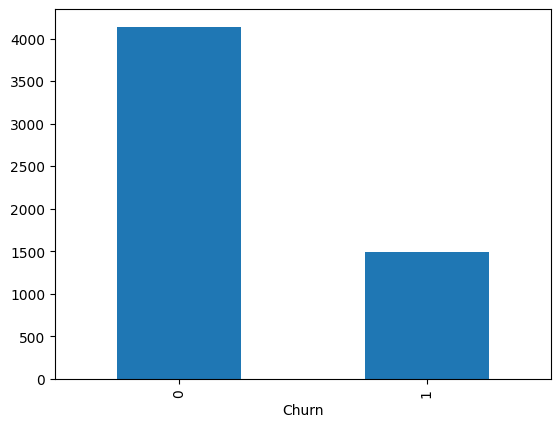

In [16]:
y_train.value_counts().plot(kind='bar')

In [17]:
np.savez('artifacts/X_train.npz', X_train)
np.savez('artifacts/X_test.npz', X_test)
np.savez('artifacts/y_train.npz', y_train)
np.savez('artifacts/y_test.npz', y_test)